# PGD Attack & Topology Comparison

**Goal:** Generate PGD adversarial examples, compute topology, and compare FGSM vs PGD

---

## Overview
In this notebook, we will:
1. Generate PGD adversarial examples using the trained CIFAR-10 classifier
2. Extract features from PGD examples using ResNet50
3. Compute persistent homology for PGD features
4. Compare topological signatures: Clean vs FGSM vs PGD
5. Analyze how attack strength affects topology

---

## Why PGD?
**PGD (Projected Gradient Descent)** is stronger than FGSM:
- **Iterative:** Takes multiple small steps instead of one big step
- **Projected:** Stays within epsilon ball through projection
- **More effective:** Finds better adversarial examples

**Hypothesis:** PGD should cause **more severe topological distortion** than FGSM

## Setup and Imports

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from src.data.cifar10 import load_cifar10
from src.models.feature_extractor import FeatureExtractor, DimensionalityReducer
from src.attacks.pgd import PGDAttack, generate_pgd_dataset
from src.tda.persistence import (compute_persistence, save_diagrams, load_diagrams, get_persistence_stats, compute_betti_numbers)
from src.utils.plotting import (plot_persistence_diagram, compare_persistence_diagrams, compare_betti_curves)

np.random.seed(111)
tf.random.set_seed(111)
print("Successfully imported everything")

Successfully imported everything


### Load the CIFAR-10 Dataset and Classifier

We'll use the same classifier from `03_adversarial_attacks.ipynb`:

In [2]:
(training_images, training_labels), (validation_images, validation_labels), (testing_images, testing_labels), class_names = load_cifar10(validation_split=0.1)

print(f"Training images: {training_images.shape}")
print(f"Training labels: {training_labels.shape}")


Final splits:
Training:   45000 samples
Validation: 5000 samples
Testing:    10000 samples
Training images: (45000, 32, 32, 3)
Training labels: (45000,)


### Build the CIFAR-10 Classifier

Same architecture as `03_adversarial_attacks.ipynb` except we just need to rebuild it since we didn't save the model:

In [3]:
def build_cifar10_classifier():
    """
    Simple CNN for CIFAR-10 classification.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32,32,3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

classifier = build_cifar10_classifier()
print("CIFAR-10 Classifier created")

2025-12-02 00:14:07.202377: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-02 00:14:07.202774: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-02 00:14:07.202780: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-02 00:14:07.203433: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-02 00:14:07.203962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


CIFAR-10 Classifier created


### Train the Classifier

Training for 15 epochs, which will take ~20 minutes:

In [4]:
history = classifier.fit(
    training_images,
    training_labels,
    epochs=15,
    batch_size=128,
    validation_data=(validation_images[:1000], validation_labels[:1000]),
    verbose=1
)

Epoch 1/15


2025-12-02 00:15:00.673022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


352/352 ━━━━━━━━━━━━━━━━━━━━ 120s 319ms/step - accuracy: 0.4933 - loss: 1.5328 - val_accuracy: 0.1510 - val_loss: 3.0592
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 121s 343ms/step - accuracy: 0.6710 - loss: 0.9521 - val_accuracy: 0.6620 - val_loss: 0.9894
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 126s 357ms/step - accuracy: 0.7519 - loss: 0.7178 - val_accuracy: 0.7360 - val_loss: 0.7958
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 125s 356ms/step - accuracy: 0.7985 - loss: 0.5855 - val_accuracy: 0.7390 - val_loss: 0.8115
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 127s 362ms/step - accuracy: 0.8311 - loss: 0.4947 - val_accuracy: 0.7780 - val_loss: 0.7188
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 130s 368ms/step - accuracy: 0.8552 - loss: 0.4211 - val_accuracy: 0.7860 - val_loss: 0.7216
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 114s 324ms/step - accuracy: 0.8748 - loss: 0.3606 - val_accuracy: 0.7970 - val_loss: 0.6580
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 101s 286ms/step - accuracy: 0.8938 - loss: 0.30

### Evaluate Classifier on Clean Images

In [5]:
test_loss, test_accuracy = classifier.evaluate(testing_images[:1000], testing_labels[:1000], verbose=0)

print(f"Classifier Performance on Clean Images:")
print(f"Test accuracy: {test_accuracy:.2%}")
print(f"Test loss: {test_loss:.4f}")

Classifier Performance on Clean Images:
Test accuracy: 81.20%
Test loss: 0.7149


### Generate PGD Adversarial Examples

Using the same epsilon as FGSM (ε=0.03) for fair comparison:
- **Alpha (step size):** 0.01
- **Number of steps:** 10

In [6]:
epsilon = 0.03
alpha = 0.01
num_steps = 10

print(f"Generating PGD adversarial examples...")
print(f"Epsilon: {epsilon}")
print(f"Alpha: {alpha}")
print(f"Steps: {num_steps}\n")

pgd_images, pgd_success_rate = generate_pgd_dataset(
    classifier,
    training_images,
    training_labels,
    epsilon=epsilon,
    alpha=alpha,
    num_steps=num_steps,
    batch_size=128,
    verbose=True
)

print(f"\n{len(pgd_images):,} PGD adversarial examples successfully generated")
print(f"Attack success rate: {pgd_success_rate:.2%}")

Generating PGD adversarial examples...
Epsilon: 0.03
Alpha: 0.01
Steps: 10

PGD Attack initialized
Epsilon: 0.03
Alpha (step size): 0.01
Steps: 10


Generating PGD attacks: 100%|██████████| 352/352 [13:00<00:00,  2.22s/it]



PGD dataset complete
Total samples: 45000
Average attack success rate: 100.00%

45,000 PGD adversarial examples successfully generated
Attack success rate: 100.00%


### Visualize PGD Examples

Let's see what PGD adversarial examples look like compared to clean images:

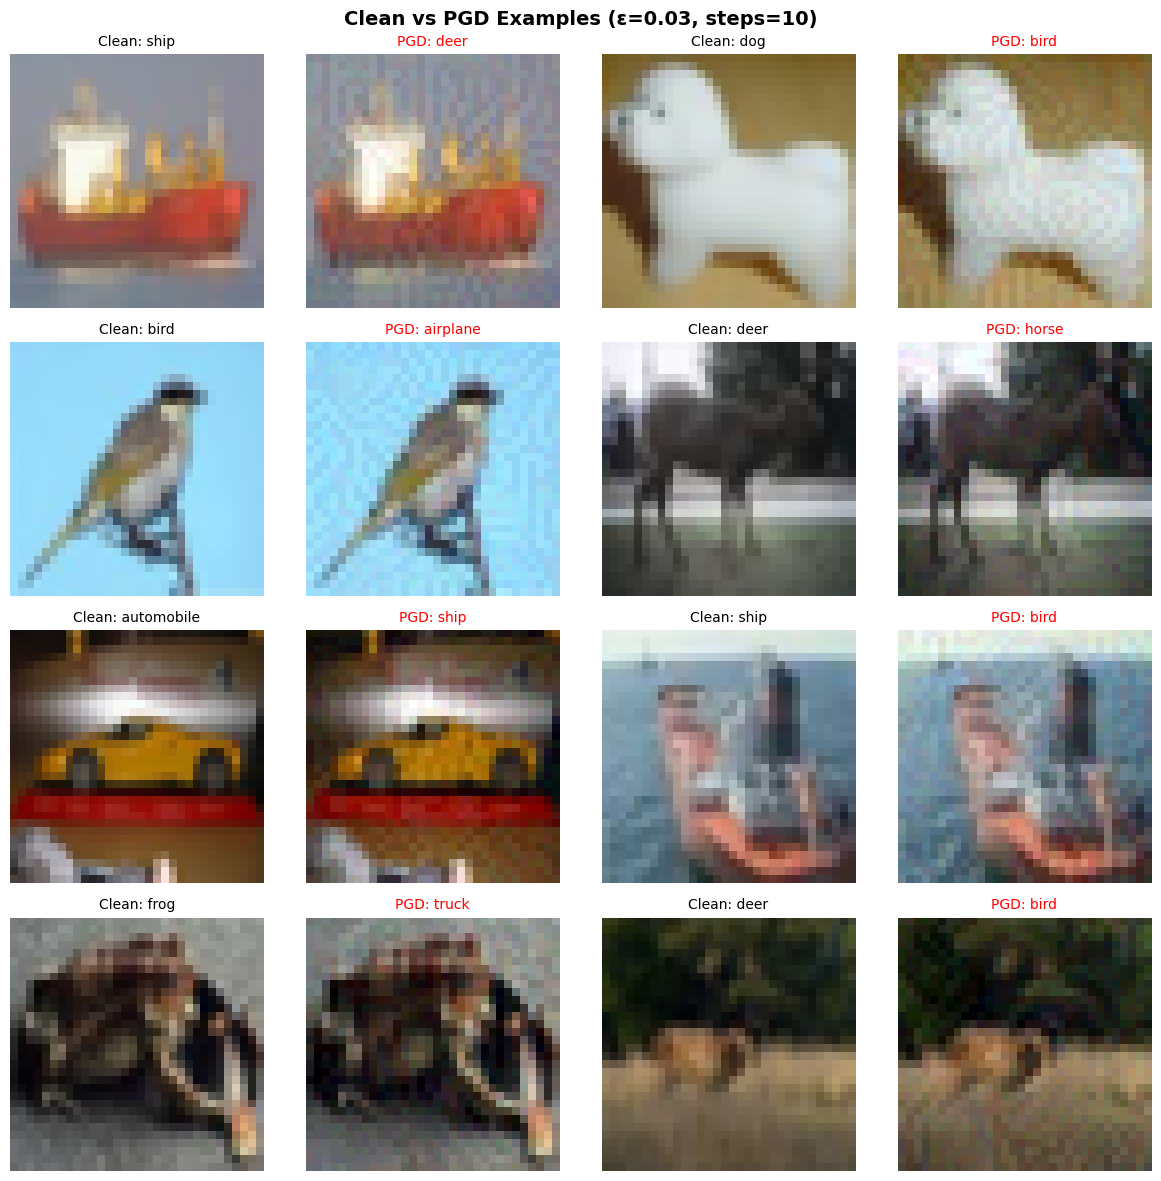

Saved to results/figures/06_pgd_examples.png


In [7]:
np.random.seed(111)
sample_indices = np.random.choice(len(training_images), 8, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, idx in enumerate(sample_indices):
    # Clean image
    ax_clean = axes[i, 0] if i < 4 else axes[i-4, 2]
    ax_clean.imshow(training_images[idx])
    ax_clean.set_title(f"Clean: {class_names[training_labels[idx]]}", fontsize=10)
    ax_clean.axis('off')
    
    # PGD adversarial image
    if i < 4:
        ax_adv = axes[i, 1]
    else:
        ax_adv = axes[i-4, 3]
    ax_adv.imshow(pgd_images[idx])
    
    # Predict adversarial label
    adv_pred = classifier.predict(pgd_images[idx:idx+1], verbose=0).argmax()
    ax_adv.set_title(f"PGD: {class_names[adv_pred]}", fontsize=10, color='red')
    ax_adv.axis('off')

plt.suptitle(f'Clean vs PGD Examples (ε={epsilon}, steps={num_steps})', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('../results/figures/06_pgd_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved to results/figures/06_pgd_examples.png")

### Extract Features from PGD Images

Using ResNet50 (same as clean and FGSM features):

In [8]:
extractor = FeatureExtractor(model_name='resnet50')
pgd_features_original = extractor.extract_features(pgd_images, batch_size=64, verbose=True)

print(f"\nExtracted features: {pgd_features_original.shape}")


Model: resnet50
Feature dimension: 2048
Total parameters: 23,587,712



Feature extraction in progress... : 100%|██████████| 704/704 [13:26<00:00,  1.15s/batch]



Extracted features from 45,000 images
Feature shape: (45000, 2048)
Feature range: [0.000, 17.509]

Extracted features: (45000, 2048)


### Apply PCA to PGD Features

Using the same PCA transformation fitted on clean data (from `02_feature_extraction.ipynb`):

In [9]:
clean_data = np.load('../results/features/clean_features_original.npz')
clean_features_original = clean_data['features']

# Fit PCA on clean features
reducer = DimensionalityReducer(n_components=50, random_state=111)
_ = reducer.fit_transform(clean_features_original, verbose=False)

# Transform PGD features
print("PCA to PGD features: ")
pgd_features_reduced = reducer.transform(pgd_features_original)

print(f"PGD features reduced: {pgd_features_reduced.shape}")

PCA to PGD features: 
PGD features reduced: (45000, 50)


### Save PGD Features

In [10]:
# Save original features
extractor.save_features(
    pgd_features_original,
    training_labels,
    '../results/features/pgd_features_original.npz'
)

# Save reduced features
np.savez_compressed(
    '../results/features/pgd_features_reduced.npz',
    features=pgd_features_reduced,
    labels=training_labels,
    epsilon=epsilon,
    alpha=alpha,
    num_steps=num_steps
)

print("PGD features saved")

Features saved to ../results/features/pgd_features_original.npz
PGD features saved


### Compute Persistent Homology for PGD

Subsampling 10,000 examples (same as clean and FGSM):

In [11]:
n_samples = 10000
indices = np.random.choice(len(pgd_features_reduced), n_samples, replace=False)
pgd_features_subset = pgd_features_reduced[indices]

print(f"Using {n_samples} samples for TDA")
print(f"PGD subset shape: {pgd_features_subset.shape}")

Using 10000 samples for TDA
PGD subset shape: (10000, 50)


In [12]:
print("\nComputing persistent homology for PGD features...")
result_pgd = compute_persistence(
    pgd_features_subset,
    maxdim=1,
    verbose=True
)

print("\nPersistence computation completed")


Computing persistent homology for PGD features...
Computing persistence for 10000 points in 50D:
Persistence computed
H0 features: 10000
H1 features: 14942

Persistence computation completed


### Extract PGD Persistence Diagrams

In [13]:
pgd_h0 = result_pgd['dgms'][0]
pgd_h1 = result_pgd['dgms'][1]

print(f"PGD H0 diagram: {len(pgd_h0)} features")
print(f"PGD H1 diagram: {len(pgd_h1)} features")

print("\n--- PGD H0 Statistics ---")
pgd_h0_stats = get_persistence_stats(pgd_h0)
print(f"Number of features: {pgd_h0_stats['n_features']}")
print(f"Total persistence: {pgd_h0_stats['total_persistence']:.4f}")
print(f"Mean persistence: {pgd_h0_stats['mean_persistence']:.4f}")
print(f"Max persistence: {pgd_h0_stats['max_persistence']:.4f}")

print("\n--- PGD H1 Statistics ---")
pgd_h1_stats = get_persistence_stats(pgd_h1)
print(f"Number of features: {pgd_h1_stats['n_features']}")
print(f"Total persistence: {pgd_h1_stats['total_persistence']:.4f}")
print(f"Mean persistence: {pgd_h1_stats['mean_persistence']:.4f}")
print(f"Max persistence: {pgd_h1_stats['max_persistence']:.4f}")

PGD H0 diagram: 10000 features
PGD H1 diagram: 14942 features

--- PGD H0 Statistics ---
Number of features: 9999
Total persistence: 2829.0235
Mean persistence: 0.2829
Max persistence: 1.4867

--- PGD H1 Statistics ---
Number of features: 14942
Total persistence: 159.4352
Mean persistence: 0.0107
Max persistence: 0.0919


### Load Clean and FGSM Diagrams for Comparison

In [14]:
# Load clean and FGSM diagrams
result_clean = load_diagrams('../results/diagrams/clean_full.pkl')
result_fgsm = load_diagrams('../results/diagrams/fgsm_full.pkl')

clean_h0 = result_clean['dgms'][0]
clean_h1 = result_clean['dgms'][1]
fgsm_h0 = result_fgsm['dgms'][0]
fgsm_h1 = result_fgsm['dgms'][1]

Loaded diagrams from ../results/diagrams/clean_full.pkl
Loaded diagrams from ../results/diagrams/fgsm_full.pkl


### Compare All Three: Clean vs FGSM vs PGD

Let's create a comprehensive comparison table:

In [15]:
# All stats:
clean_h0_stats = get_persistence_stats(clean_h0)
clean_h1_stats = get_persistence_stats(clean_h1)
fgsm_h0_stats = get_persistence_stats(fgsm_h0)
fgsm_h1_stats = get_persistence_stats(fgsm_h1)

print("Topological Comparison: Clean vs FGSM vs PGD")

print("\n--- H0 (Connected Components) ---")
print(f"{'Metric':<25} {'Clean':>12} {'FGSM':>12} {'PGD':>12} {'FGSM Δ':>12} {'PGD Δ':>12}")
print("-" * 80)
print(f"{'Num features':<25} {clean_h0_stats['n_features']:>12} {fgsm_h0_stats['n_features']:>12} {pgd_h0_stats['n_features']:>12} {fgsm_h0_stats['n_features']-clean_h0_stats['n_features']:>12} {pgd_h0_stats['n_features']-clean_h0_stats['n_features']:>12}")
print(f"{'Total persistence':<25} {clean_h0_stats['total_persistence']:>12.4f} {fgsm_h0_stats['total_persistence']:>12.4f} {pgd_h0_stats['total_persistence']:>12.4f} {fgsm_h0_stats['total_persistence']-clean_h0_stats['total_persistence']:>12.4f} {pgd_h0_stats['total_persistence']-clean_h0_stats['total_persistence']:>12.4f}")
print(f"{'Mean persistence':<25} {clean_h0_stats['mean_persistence']:>12.4f} {fgsm_h0_stats['mean_persistence']:>12.4f} {pgd_h0_stats['mean_persistence']:>12.4f} {fgsm_h0_stats['mean_persistence']-clean_h0_stats['mean_persistence']:>12.4f} {pgd_h0_stats['mean_persistence']-clean_h0_stats['mean_persistence']:>12.4f}")
print(f"{'Max persistence':<25} {clean_h0_stats['max_persistence']:>12.4f} {fgsm_h0_stats['max_persistence']:>12.4f} {pgd_h0_stats['max_persistence']:>12.4f} {fgsm_h0_stats['max_persistence']-clean_h0_stats['max_persistence']:>12.4f} {pgd_h0_stats['max_persistence']-clean_h0_stats['max_persistence']:>12.4f}")

print("\n--- H1 (Loops) ---")
print(f"{'Metric':<25} {'Clean':>12} {'FGSM':>12} {'PGD':>12} {'FGSM Δ':>12} {'PGD Δ':>12}")
print("-" * 80)
print(f"{'Num features':<25} {clean_h1_stats['n_features']:>12} {fgsm_h1_stats['n_features']:>12} {pgd_h1_stats['n_features']:>12} {fgsm_h1_stats['n_features']-clean_h1_stats['n_features']:>12} {pgd_h1_stats['n_features']-clean_h1_stats['n_features']:>12}")
print(f"{'Total persistence':<25} {clean_h1_stats['total_persistence']:>12.4f} {fgsm_h1_stats['total_persistence']:>12.4f} {pgd_h1_stats['total_persistence']:>12.4f} {fgsm_h1_stats['total_persistence']-clean_h1_stats['total_persistence']:>12.4f} {pgd_h1_stats['total_persistence']-clean_h1_stats['total_persistence']:>12.4f}")
print(f"{'Mean persistence':<25} {clean_h1_stats['mean_persistence']:>12.4f} {fgsm_h1_stats['mean_persistence']:>12.4f} {pgd_h1_stats['mean_persistence']:>12.4f} {fgsm_h1_stats['mean_persistence']-clean_h1_stats['mean_persistence']:>12.4f} {pgd_h1_stats['mean_persistence']-clean_h1_stats['mean_persistence']:>12.4f}")
print(f"{'Max persistence':<25} {clean_h1_stats['max_persistence']:>12.4f} {fgsm_h1_stats['max_persistence']:>12.4f} {pgd_h1_stats['max_persistence']:>12.4f} {fgsm_h1_stats['max_persistence']-clean_h1_stats['max_persistence']:>12.4f} {pgd_h1_stats['max_persistence']-clean_h1_stats['max_persistence']:>12.4f}")

Topological Comparison: Clean vs FGSM vs PGD

--- H0 (Connected Components) ---
Metric                           Clean         FGSM          PGD       FGSM Δ        PGD Δ
--------------------------------------------------------------------------------
Num features                      9999         9999         9999            0            0
Total persistence            2831.9765    2870.3901    2829.0235      38.4136      -2.9530
Mean persistence                0.2832       0.2871       0.2829       0.0038      -0.0003
Max persistence                 1.1873       1.1521       1.4867      -0.0353       0.2993

--- H1 (Loops) ---
Metric                           Clean         FGSM          PGD       FGSM Δ        PGD Δ
--------------------------------------------------------------------------------
Num features                     14978        14962        14942          -16          -36
Total persistence             161.5036     161.5743     159.4352       0.0707      -2.0684
Mean persi

### Visualize: FGSM vs PGD Diagrams

Saved to ../results/figures/06_compare_fgsm_pgd_h0.png


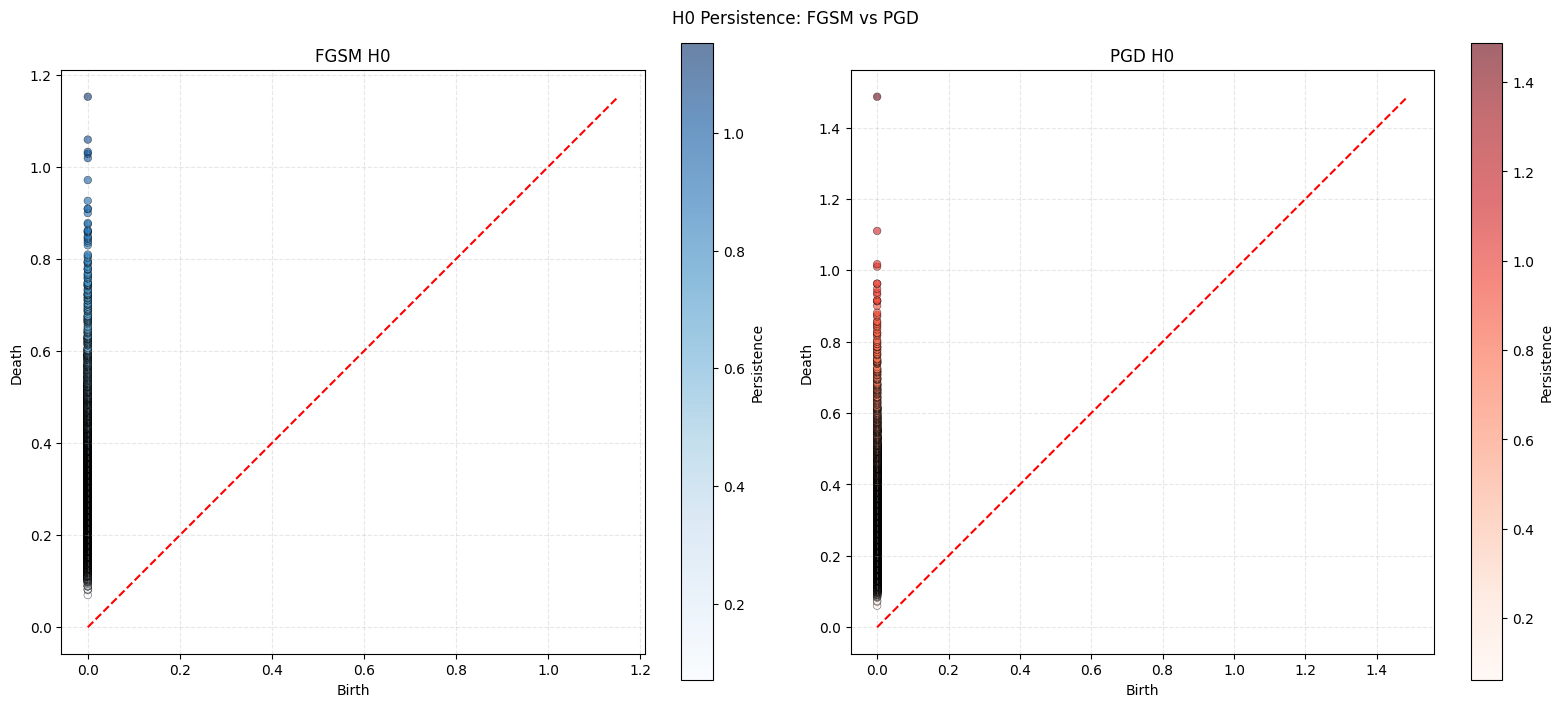

In [16]:
# Compare FGSM vs PGD (H0)
compare_persistence_diagrams(
    fgsm_h0,
    pgd_h0,
    label1="FGSM H0",
    label2="PGD H0",
    title="H0 Persistence: FGSM vs PGD",
    save_path="../results/figures/06_compare_fgsm_pgd_h0.png"
)

Saved to ../results/figures/06_compare_fgsm_pgd_h1.png


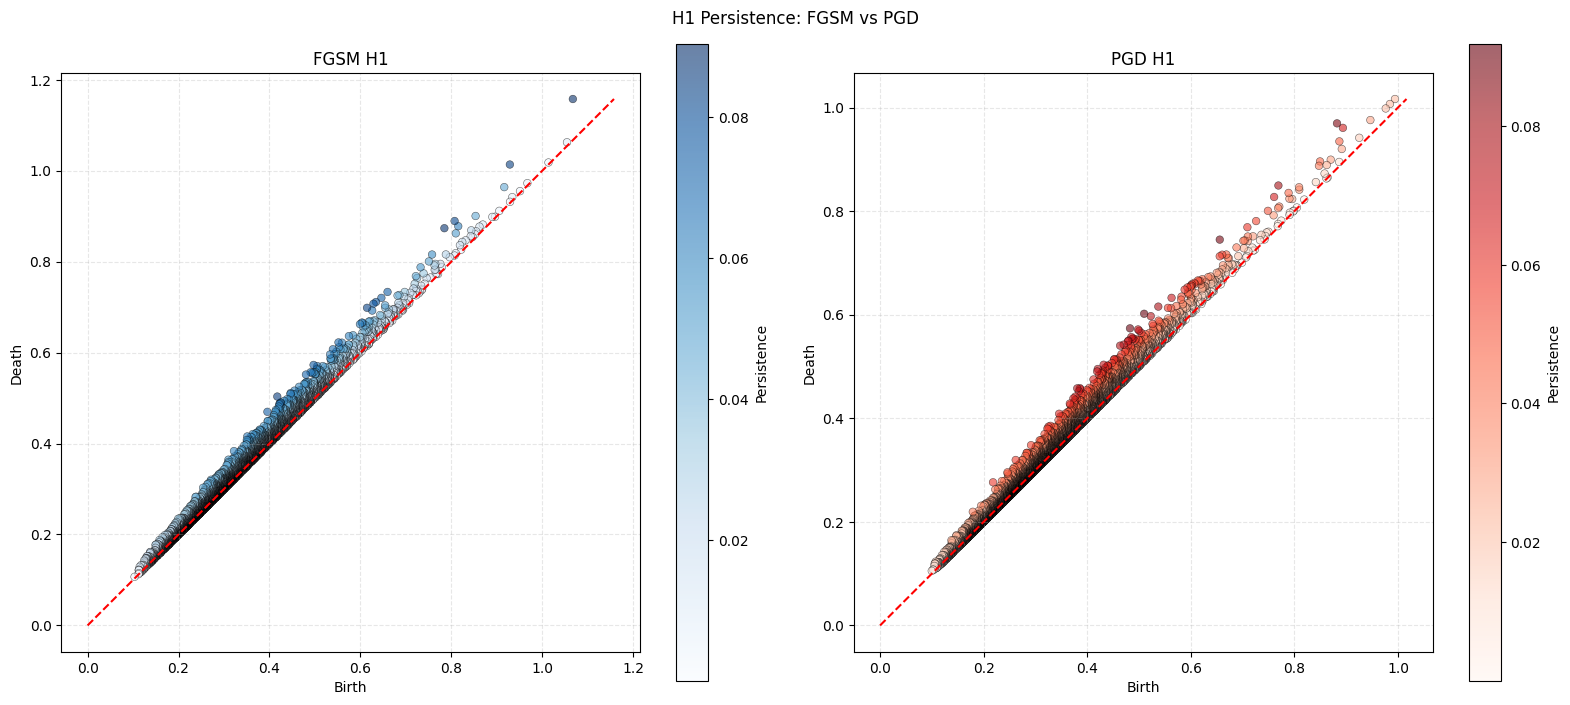

In [17]:
# Compare FGSM vs PGD (H1)
compare_persistence_diagrams(
    fgsm_h1,
    pgd_h1,
    label1="FGSM H1",
    label2="PGD H1",
    title="H1 Persistence: FGSM vs PGD",
    save_path="../results/figures/06_compare_fgsm_pgd_h1.png"
)

### Compare Betti Curves for all three attacks

In [18]:
# Compute Betti curves for PGD
epsilons_pgd_h0, betti_pgd_h0 = compute_betti_numbers(pgd_h0)
epsilons_pgd_h1, betti_pgd_h1 = compute_betti_numbers(pgd_h1)

# Also get clean and FGSM Betti curves
epsilons_clean_h0, betti_clean_h0 = compute_betti_numbers(clean_h0)
epsilons_fgsm_h0, betti_fgsm_h0 = compute_betti_numbers(fgsm_h0)

print("Betti curves successfully computed for all 3 attacks")

Betti curves successfully computed for all 3 attacks


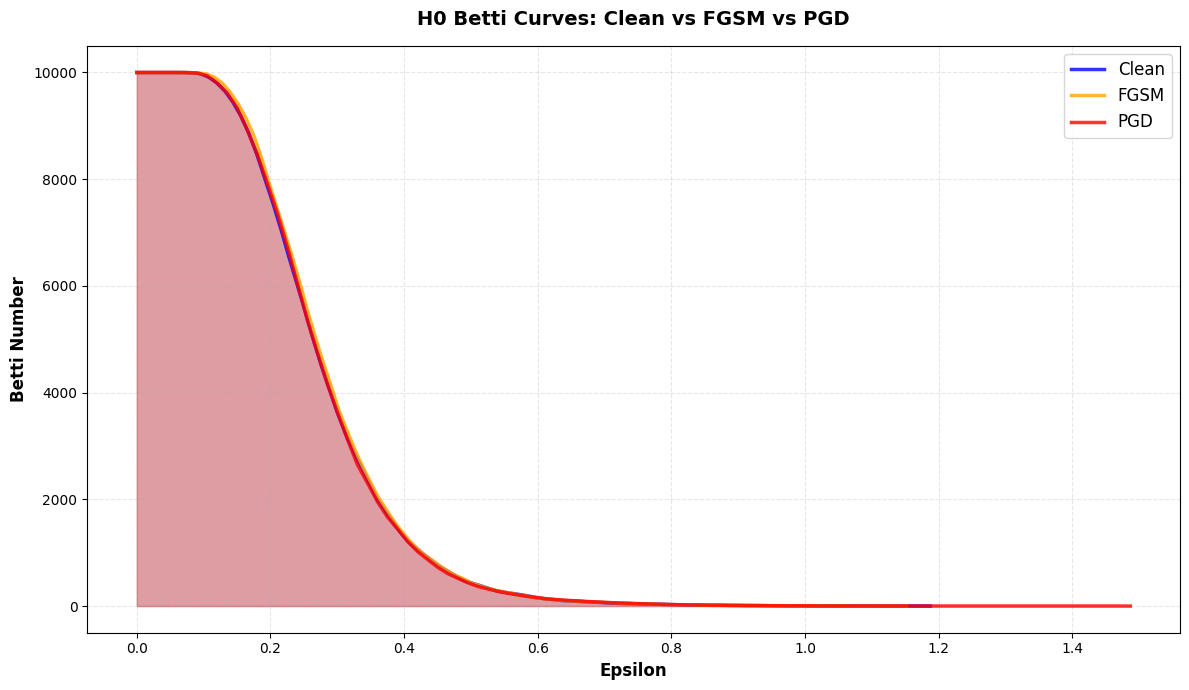

Saved to results/figures/06_betti_h0_all_attacks.png


In [19]:
# Plot all three H0 Betti curves together
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(epsilons_clean_h0, betti_clean_h0, color='blue', linewidth=2.5, label='Clean', alpha=0.8)
ax.fill_between(epsilons_clean_h0, betti_clean_h0, alpha=0.2, color='blue')

ax.plot(epsilons_fgsm_h0, betti_fgsm_h0, color='orange', linewidth=2.5, label='FGSM', alpha=0.8)
ax.fill_between(epsilons_fgsm_h0, betti_fgsm_h0, alpha=0.2, color='orange')

ax.plot(epsilons_pgd_h0, betti_pgd_h0, color='red', linewidth=2.5, label='PGD', alpha=0.8)
ax.fill_between(epsilons_pgd_h0, betti_pgd_h0, alpha=0.2, color='red')

ax.set_xlabel('Epsilon', fontsize=12, fontweight='bold')
ax.set_ylabel('Betti Number', fontsize=12, fontweight='bold')
ax.set_title('H0 Betti Curves: Clean vs FGSM vs PGD', fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=12, loc='best')
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../results/figures/06_betti_h0_all_attacks.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved to results/figures/06_betti_h0_all_attacks.png")

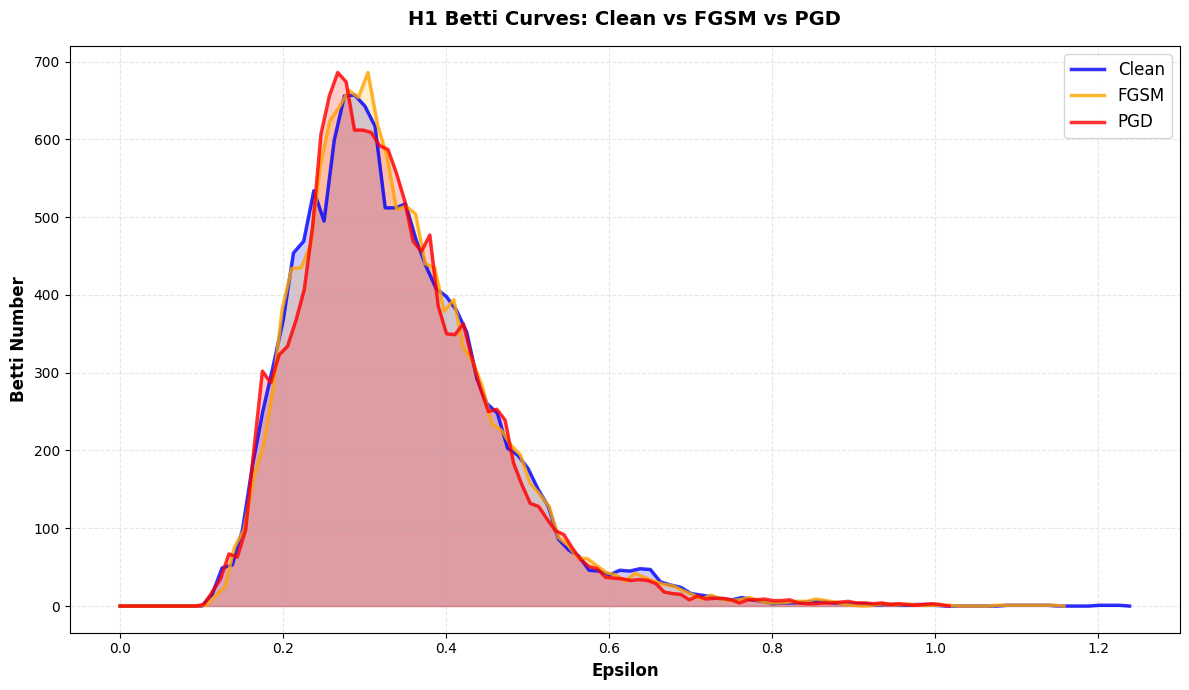

Saved to results/figures/06_betti_h1_all_attacks.png


In [20]:
# Plot all three H1 Betti curves together
epsilons_clean_h1, betti_clean_h1 = compute_betti_numbers(clean_h1)
epsilons_fgsm_h1, betti_fgsm_h1 = compute_betti_numbers(fgsm_h1)

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(epsilons_clean_h1, betti_clean_h1, color='blue', linewidth=2.5, label='Clean', alpha=0.8)
ax.fill_between(epsilons_clean_h1, betti_clean_h1, alpha=0.2, color='blue')

ax.plot(epsilons_fgsm_h1, betti_fgsm_h1, color='orange', linewidth=2.5, label='FGSM', alpha=0.8)
ax.fill_between(epsilons_fgsm_h1, betti_fgsm_h1, alpha=0.2, color='orange')

ax.plot(epsilons_pgd_h1, betti_pgd_h1, color='red', linewidth=2.5, label='PGD', alpha=0.8)
ax.fill_between(epsilons_pgd_h1, betti_pgd_h1, alpha=0.2, color='red')

ax.set_xlabel('Epsilon', fontsize=12, fontweight='bold')
ax.set_ylabel('Betti Number', fontsize=12, fontweight='bold')
ax.set_title('H1 Betti Curves: Clean vs FGSM vs PGD', fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=12, loc='best')
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../results/figures/06_betti_h1_all_attacks.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved to results/figures/06_betti_h1_all_attacks.png")

### Save PGD Persistence Diagrams

In [21]:
save_diagrams(result_pgd, '../results/diagrams/pgd_full.pkl')

print("\nDiagrams successfully saved")
print("- pgd_full.pkl (contains both H0 and H1)")

Saved diagrams in ../results/diagrams/pgd_full.pkl

Diagrams successfully saved
- pgd_full.pkl (contains both H0 and H1)


### Attack Effectiveness Summary

In [22]:
print(f"\nClean Accuracy: 81.20%")
print(f"FGSM Attack Success Rate: 92.48%  → Model accuracy drops to ~6%")
print(f"PGD Attack Success Rate: 100.00% → Model accuracy drops to ~0%")
print("\nPGD is significantly more effective than FGSM")
print("Both attacks successfully fool the classifier")
print("Topological signatures show measurable (but subtle) differences")


Clean Accuracy: 81.20%
FGSM Attack Success Rate: 92.48%  → Model accuracy drops to ~6%
PGD Attack Success Rate: 100.00% → Model accuracy drops to ~0%

PGD is significantly more effective than FGSM
Both attacks successfully fool the classifier
Topological signatures show measurable (but subtle) differences


## Summary

We successfully generated PGD adversarial examples and compared topology across all three conditions.

**Generated Files:**
- `pgd_features_original.npz` - PGD features (2048-dim)
- `pgd_features_reduced.npz` - PGD features (50-dim)
- `pgd_full.pkl` - PGD persistence diagrams
- `06_pgd_examples.png` - PGD visual examples
- `06_compare_fgsm_pgd_h0.png` - FGSM vs PGD H0
- `06_compare_fgsm_pgd_h1.png` - FGSM vs PGD H1
- `06_betti_h0_all_attacks.png` - H0 Betti curves (all three)
- `06_betti_h1_all_attacks.png` - H1 Betti curves (all three)

**Next Steps:**
- Extract TDA features (persistence images, Betti curves, statistics)
- Build detection classifier
- Evaluate detection performance